## Visualisation
This code uses the output from MWATS_average_SQL and provides basic visualisation functionality. 

In [1]:
import requests
import numpy as np
import plots as pl
import pandas as pd
import matplotlib.pyplot as plt 
import aplpy 
import os
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy import units as u
from astropy.coordinates import SkyCoord

/Users/134393/anaconda3/lib/python3.7/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [2]:
def query(ra, dec, radius=5):
    url = f"http://simbad.u-strasbg.fr/simbad/sim-coo?Coord={ra}d{dec}d&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius={radius}&Radius.unit=arcmin&submit=submit+query"
    return url

In [3]:
def get_response(ra, dec, radius=5):
    url = query(ra, dec, radius)
    response = requests.get(url)
    tables = pd.read_html(response.text)
    idx = np.argmax(['Identifier' in t.columns for t in tables])
    table = tables[idx]
    try:
        identifier = table.loc[0, 'Identifier']
    except KeyError:
        identifier = 'No object found'
    return identifier, url, table

In [4]:
# Generic function for plotting light-curves and stats.
def plot_lc(source):
  exists = os.path.isfile('thumbs/'+str(source)+'_Avg_LC.jpg')
  if not exists: 
    all = filtered_raw_data[filtered_raw_data.source_id == source]
    all = all.sort_values(by='jd')
    plt.figure(figsize=(7, 8))
    plt.subplot(2,1,1)
    f = list(all.raw_peak_flux)
    s_stats = stats[stats.source_id == source]
    plt.title(str(source)+' RA='+str(round(s_stats.ra.values[0], 3))+' DEC='+str(round(s_stats.dec.values[0], 3)))
    #plt.title(str(source)+' RA='+str(s_stats.ra)+' DEC='+str(s_stats.dec))
    plt.plot(list(f), 'k.', label='Flux')
    plt.xlabel('Observation Number')
    plt.ylabel('Flux (Jy)')
    # Non-averaged
    plt.subplot(2,1,2)
    plt.plot(all.jd, all.raw_peak_flux, 'k.', label='Flux')
    ts = []
    ys = []
    for t in all.jd:
        sli = stats[stats.source_id == source]
        y = (sli.grad * t) + sli.y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'k-.', label='$\\nabla_{S} = $'+str( round(float(sli.sig),2) ))
        
    # Averaged 
    avg = filtered_raw_avg_data[filtered_raw_avg_data.source_id == source]
    plt.errorbar(avg.mean_jd, avg.median_flux, avg.std_flux, fmt='ro', label="Median flux", markersize=10)
    ts = []
    ys = []
    for t in avg.mean_jd:
        sli = stats[stats.source_id == source]
        y = (sli.avg_grad * t) + sli.avg_y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'r-.', label='Median $\\nabla_{S} = $'+str( round(float(sli.avg_sig),2) ))
    #plt.ylim(np.mean(f)*0.8, np.mean(f)*1.2)
    plt.xlabel('Time (JD)')
    plt.ylabel('Flux (Jy)')
    plt.savefig('thumbs/'+str(source)+'_Avg_LC.jpg')
    plt.legend()
    plt.close

In [5]:
def get_image(source_id):
    exists = os.path.isfile('thumbs/'+str(source_id)+'.jpg')
    if not exists:
        # Select random image
        plt.figure(figsize=[10,12])
        image = filtered_raw_data[filtered_raw_data.source_id == source_id].image.sample(1).values[0]
        s_stats = stats[stats.source_id == source_id]
        grid = True
        size=(500, 500)
        dpi = 40
        figure = aplpy.FITSFigure('/Volumes/BEL27A-BKP01/MWATS/'+image, dimensions=[0,1], slices=[0,0], auto_refresh=False, dpi = dpi, figsize = (size[0] / float(dpi), size[1] / float(dpi)))
        ra = s_stats.ra.values[0]
        dec = s_stats.dec.values[0]
        circle_size = 1.0 # 1 degree circle
        figure.recenter(ra, dec, radius=1.0, width=2.0, height=2.0)
        #figure.recenter(ra, dec, circle_size) 
        if grid:
            try:
                figure.add_grid()
            except Exception as e:
                logging.warn("APLpy error adding grid to image: {0}".format(e))
        # Adjust the axis labels, otherwise they overlap
        # If the image is less than two arc minutes across, show seconds on the tick labels
    
        image_radius = circle_size
        if image_radius < 1.0 / 60.0 * 2:
                figure.tick_labels.set_xformat("hh:mm:ss")
                figure.tick_labels.set_yformat("dd:mm:ss")
        else:
                figure.tick_labels.set_xformat("hh:mm")
                figure.tick_labels.set_yformat("dd:mm")

        figure.tick_labels.set_xformat("dd:mm")
        figure.tick_labels.set_yformat("dd:mm")
        figure.show_grayscale(pmin=5.0, pmax=99.5, invert=False)
        #figure.add_colorbar()
        # Show locations of the neighbours
        figure.show_rectangles(ra, dec, 0.1, 0.1, edgecolor='k', linewidth=2.0)
        n = neighbours[neighbours.source_id == source_id]
        for num in range(5):
            if num == 0:
               neigh = n.n_id1.values[0]
               nra  =  n.n_id1_ra.values[0]
               ndec =  n.n_id1_dec.values[0]
               colour = 'm'
            if num == 1:
               neigh = n.n_id2.values[0]
               nra  =  n.n_id2_ra.values[0]
               ndec =  n.n_id2_dec.values[0]
               colour = 'y'
            if num == 2:
               neigh = n.n_id3.values[0]
               nra  =  n.n_id3_ra.values[0]
               ndec =  n.n_id3_dec.values[0]
               colour = 'c'
            if num == 3:
               neigh = n.n_id4.values[0]
               nra  =  n.n_id4_ra.values[0]
               ndec =  n.n_id4_dec.values[0]
               colour = 'b'
            if num == 4:
               neigh = n.n_id5.values[0]
               nra  =  n.n_id5_ra.values[0]
               ndec =  n.n_id5_dec.values[0]
               colour = 'r'
            figure.show_ellipses(nra, ndec, 0.1, 0.1, edgecolor=colour, linewidth=2.0)
        figure.axis_labels.set_font(size = 30.0)
        figure.tick_labels.set_font(size = 30.0)
        figure.add_colorbar()
        figure.colorbar.set_font(size = 30.0)
        figure.colorbar.set_axis_label_font(size = 30.0)
        figure.colorbar.set_axis_label_text('Jy / beam')
        figure.save('thumbs/'+str(source_id)+'.jpg')
        figure.close()

In [6]:
def plot_n_lc(source):
  exists = os.path.isfile('thumbs/'+str(source)+'_LCS.jpg')
  if not exists:
    plt.figure(figsize=[8,6])
    gs = gridspec.GridSpec(3, 2)
    n = neighbours[neighbours.source_id == source]
    for num in range(5):
        if num == 0:
               neigh = n.n_id1.values[0]
               colour = 'm'
        if num == 1:
               neigh = n.n_id2.values[0]
               colour = 'y'
        if num == 2:
               neigh = n.n_id3.values[0]
               colour = 'c'
        if num == 3:
               neigh = n.n_id4.values[0]
               colour = 'b'
        if num == 4:
               neigh = n.n_id5.values[0]
               colour = 'r'
        plt.subplot(gs[num])    
        s_stats = stats[stats.source_id == source]
        main = filtered_raw_data[filtered_raw_data.source_id == source]
        main = main.sort_values(by='jd')
        n = neighbours[neighbours.source_id == source]
        n_data = filtered_raw_data[filtered_raw_data.source_id == neigh]
        n_data = n_data.sort_values(by='jd')

        main = main.set_index('time')
        n_data = n_data.set_index('time')

        result = pd.concat([main, n_data])
        result = result.sort_values(by='time')

        image_ids = list(result.image_id)

        count = 0
        counts = []
        counts.append(count)
        for i in range(len(image_ids)-1):
            if image_ids[i+1]-image_ids[i] == 0:
               count = count
            else: 
               count = count + 1
            counts.append(count)

        result['counts'] = counts

        p1 = result[result.source_id == source] 
        p2 = result[result.source_id == neigh]
    
        plt.plot(p2.counts, p2.raw_peak_flux, color=colour, markersize=5, marker='.', label='Neighbour', alpha=0.5)
        plt.plot(p1.counts, p1.raw_peak_flux, 'ko-.', label='Main', alpha=0.5)

        plt.ylabel('Flux (Jy)')
        plt.xlabel('Image sequence (N)')
    
    # Plot the gain
    plt.subplot(gs[5])
    plt.plot(list(main.Gain), 'ko', alpha=0.5)
    plt.ylabel('Gain')
    plt.xlabel('Image sequence (N)')
    plt.tight_layout()
    plt.savefig('thumbs/'+str(source)+'_LCS.jpg')
    plt.close()
    return result


In [7]:
# Load the data
stats = pd.read_feather('stats_table.fth')
filtered_raw_data = pd.read_feather('data.fth')
filtered_raw_avg_data = pd.read_feather('avg_data.fth')
neighbours = pd.read_feather('neighbours.fth')

# Add extra column for average correlation
#stats['avg_corr'] = stats.iloc[:, [21,22,23,24,25]].mean(axis=1)

### View interesting light-curves:

In [34]:
avg_sig_cut = 0.0
avg_flux_cut = 0.0
avg_Mod_cut = 10.0
Mod_cut = 0.0
F = 0
p = 1e-10
corr_cut = 0.3

interesting = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut)
             & (stats.p_k < p)   
             & (stats.x_corr_1 < corr_cut) 
             & (stats.x_corr_2 < corr_cut)
             & (stats.x_corr_3 < corr_cut)
             & (stats.x_corr_4 < corr_cut)
             & (stats.x_corr_5 < corr_cut)]

len(interesting) # How many objects we have in our cut.

78

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.095e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.074e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.781e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.008e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.645e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.766e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.744e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.797e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.879e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.848e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.435e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.088e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.383e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.075e+00 [aplpy.core]

/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Auto-setting vmin to -4.676e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.771e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.177e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.610e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.775e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.850e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.747e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.847e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.046e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.901e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.412e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.854e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.674e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.820e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.845e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.835e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.765e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.189e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.070e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.116e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.200e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.606e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.038e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.737e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.796e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.808e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.675e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.812e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.924e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.250e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.401e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.027e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.799e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.831e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.668e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.801e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.848e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.641e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.097e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.959e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.061e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.889e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.400e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.083e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.361e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.071e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.486e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.691e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.725e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.807e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.163e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.493e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.404e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.365e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.805e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.814e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.093e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.957e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.265e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.407e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.547e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.487e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.332e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.102e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.470e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.471e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.561e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.496e-01 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.804e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.684e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.859e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.274e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.660e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.546e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.699e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.659e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.659e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.196e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.596e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.179e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.994e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.313e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.802e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.613e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.345e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.109e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.351e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.428e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.620e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.187e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.718e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.117e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.707e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.234e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.081e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.362e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.327e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.440e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.592e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.510e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.755e-01 [aplpy.core]
INFO: Auto-setting vmax to  9.084e-01 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.980e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.307e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.594e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.601e-01 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.078e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.023e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.040e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.340e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.596e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.018e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.923e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.839e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.530e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.635e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.923e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.839e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.524e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.702e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.175e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.379e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.974e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.921e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.953e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.942e+00 [aplpy.core]


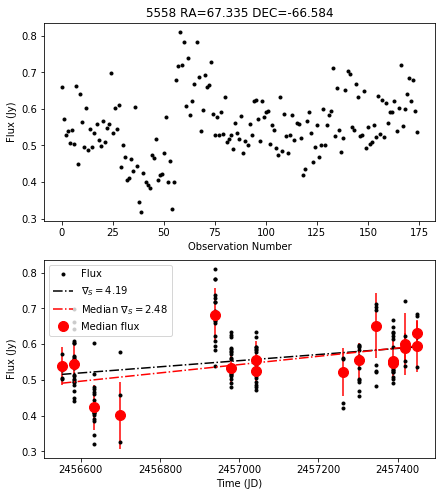

<Figure size 720x864 with 0 Axes>

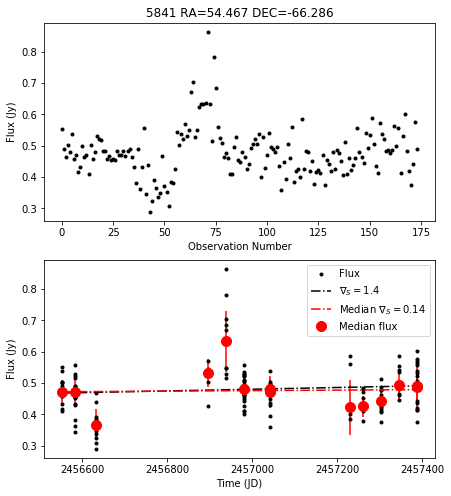

<Figure size 720x864 with 0 Axes>

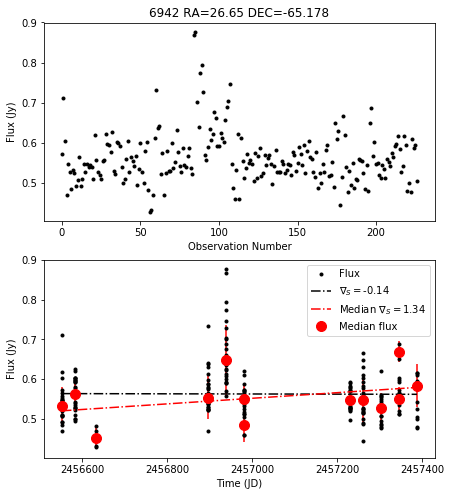

<Figure size 720x864 with 0 Axes>

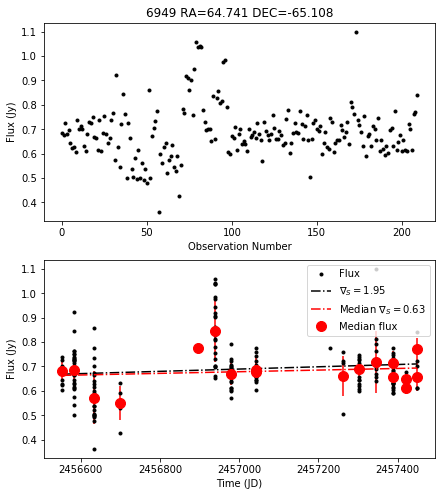

<Figure size 720x864 with 0 Axes>

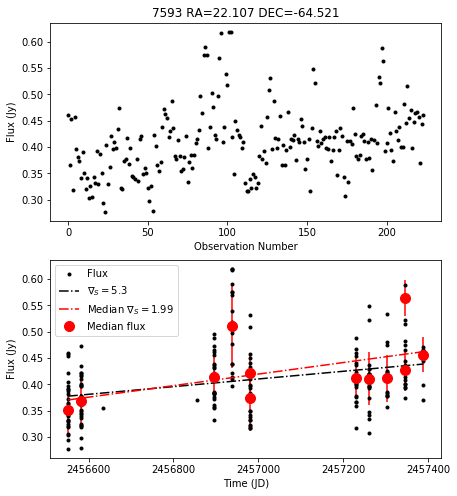

<Figure size 720x864 with 0 Axes>

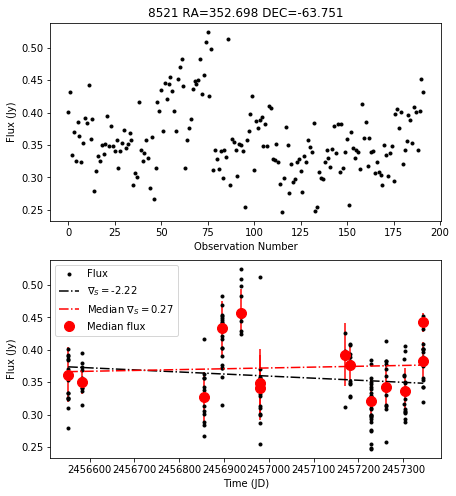

<Figure size 720x864 with 0 Axes>

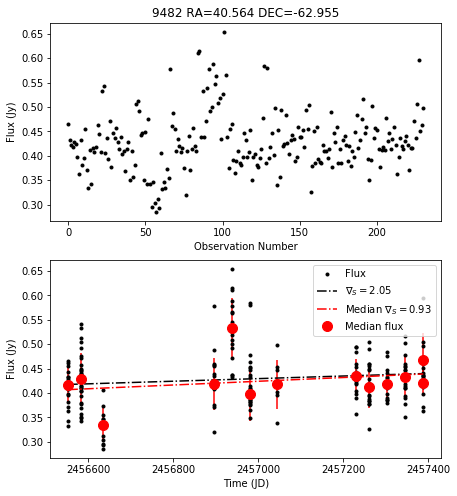

<Figure size 720x864 with 0 Axes>

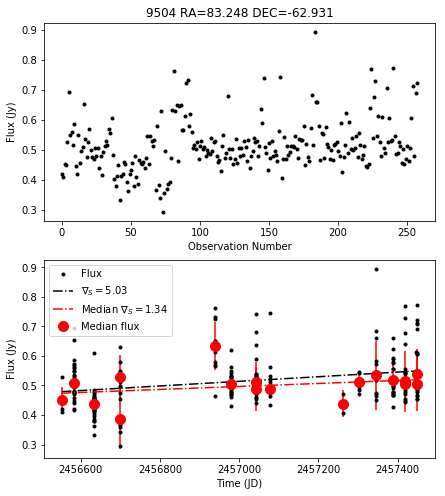

<Figure size 720x864 with 0 Axes>

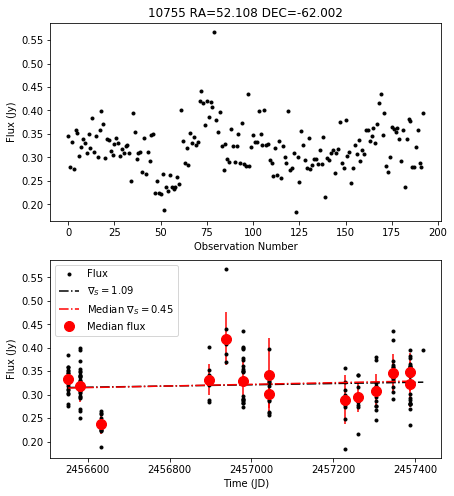

<Figure size 720x864 with 0 Axes>

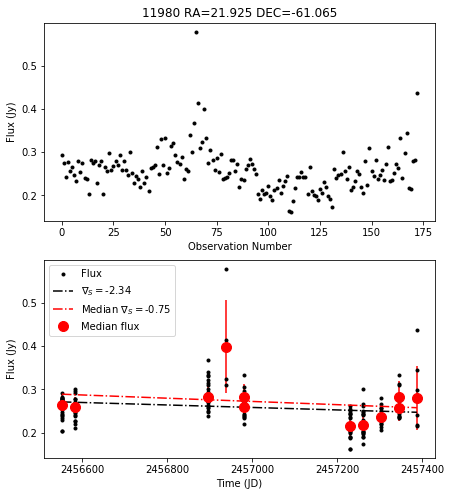

<Figure size 720x864 with 0 Axes>

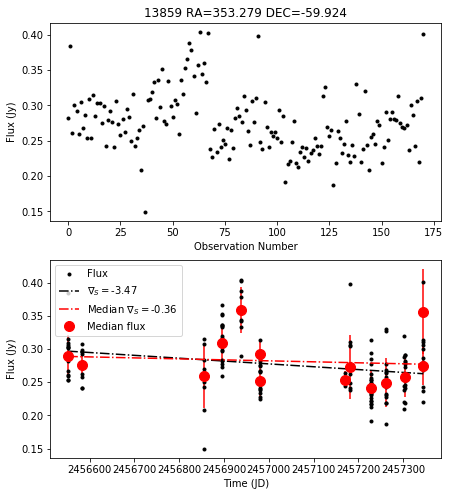

<Figure size 720x864 with 0 Axes>

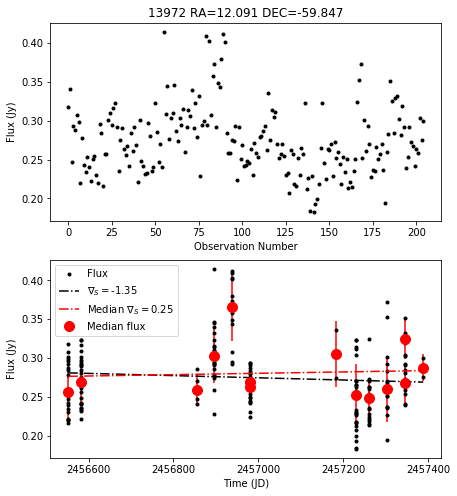

<Figure size 720x864 with 0 Axes>

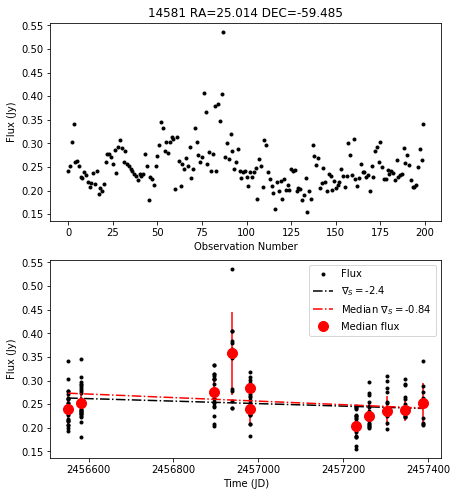

<Figure size 720x864 with 0 Axes>

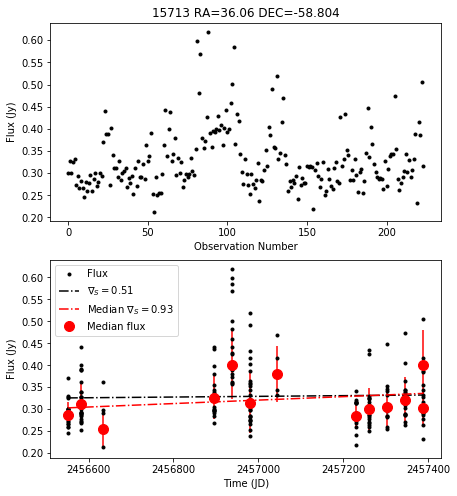

<Figure size 720x864 with 0 Axes>

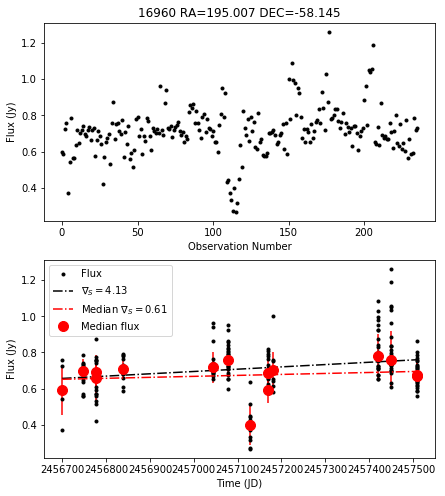

<Figure size 720x864 with 0 Axes>

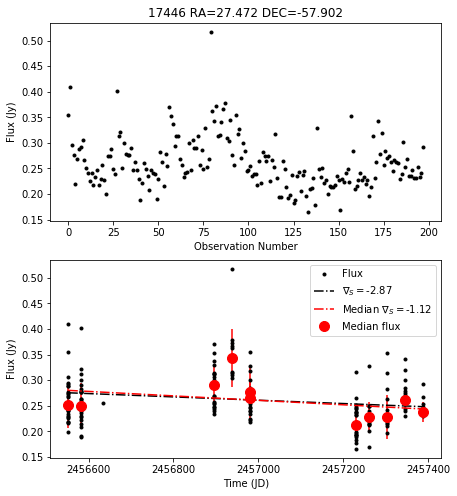

<Figure size 720x864 with 0 Axes>

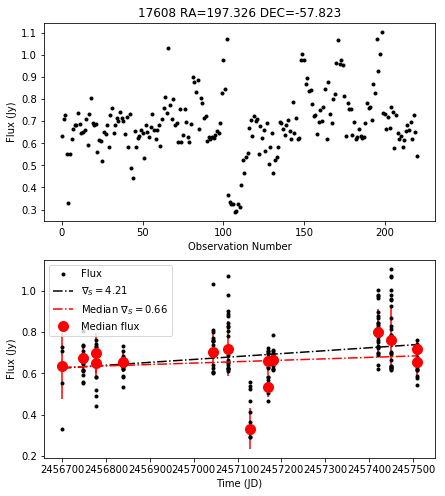

<Figure size 720x864 with 0 Axes>

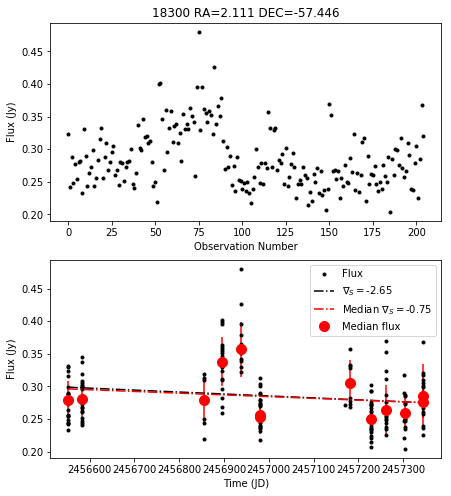

<Figure size 720x864 with 0 Axes>

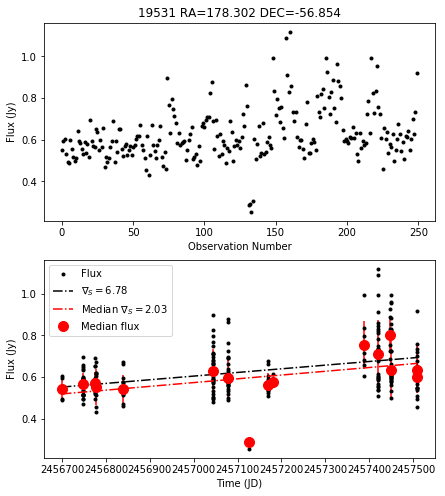

<Figure size 720x864 with 0 Axes>

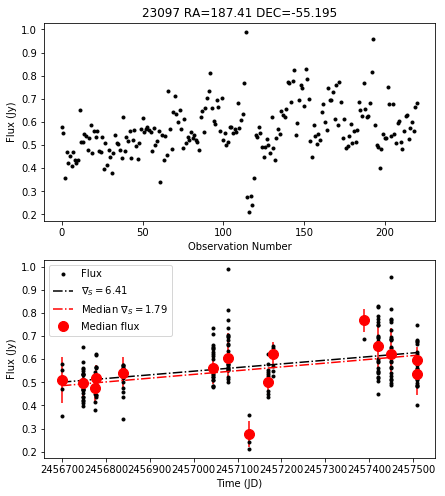

<Figure size 720x864 with 0 Axes>

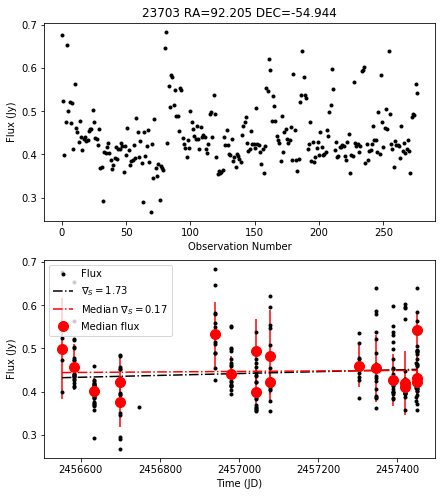

<Figure size 720x864 with 0 Axes>

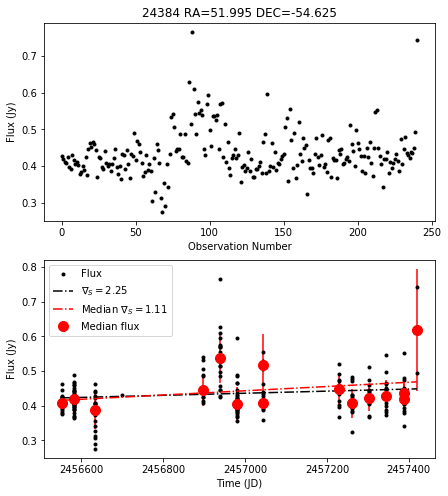

<Figure size 720x864 with 0 Axes>

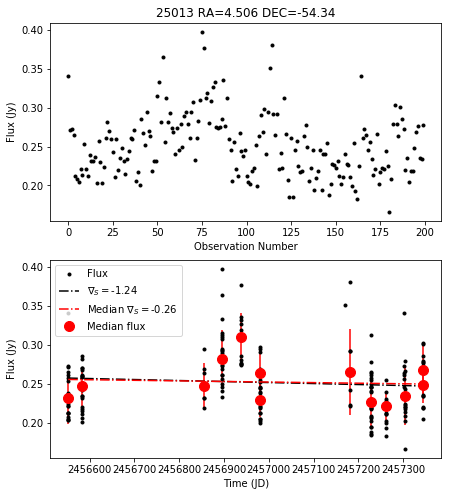

<Figure size 720x864 with 0 Axes>

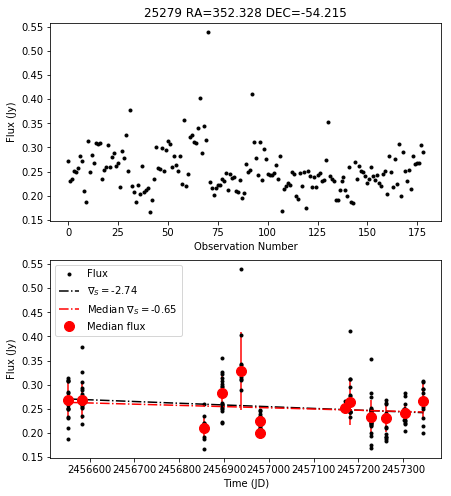

<Figure size 720x864 with 0 Axes>

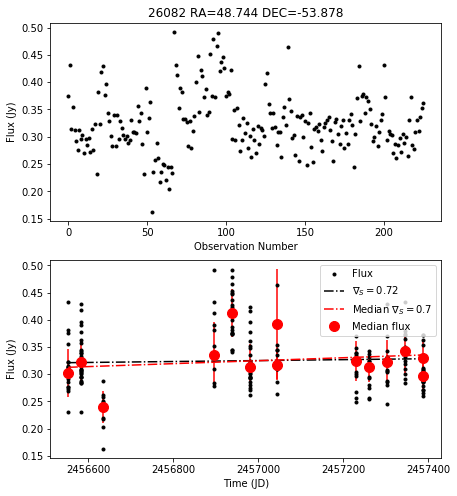

<Figure size 720x864 with 0 Axes>

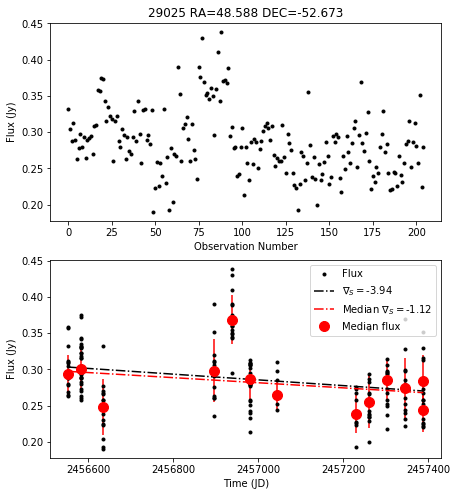

<Figure size 720x864 with 0 Axes>

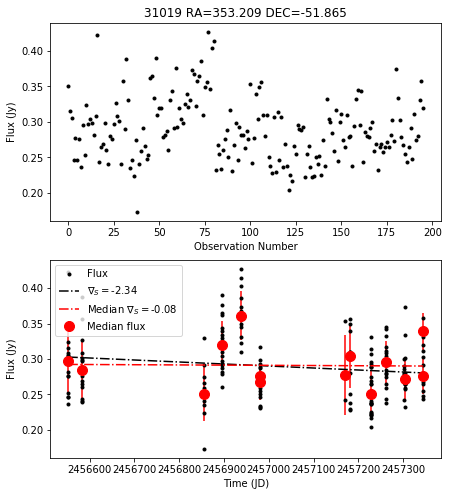

<Figure size 720x864 with 0 Axes>

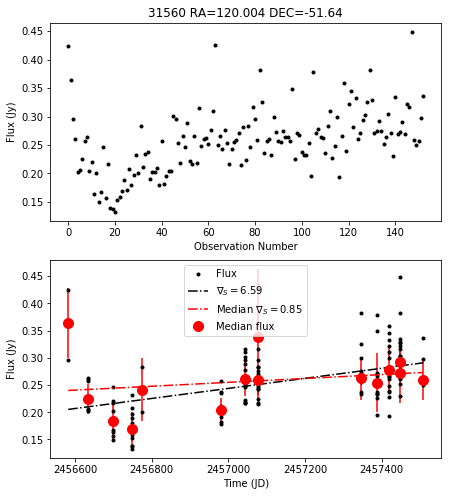

<Figure size 720x864 with 0 Axes>

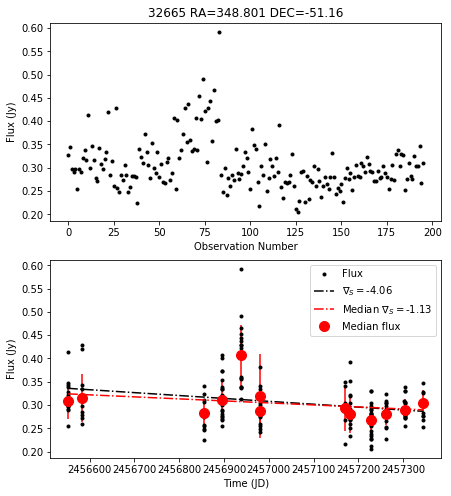

<Figure size 720x864 with 0 Axes>

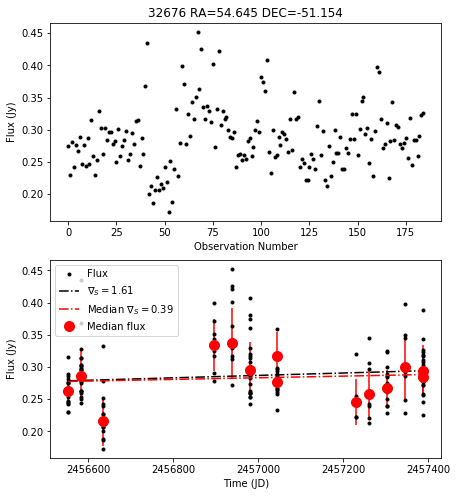

<Figure size 720x864 with 0 Axes>

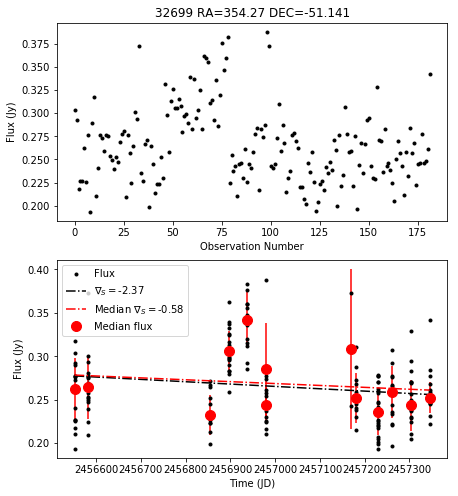

<Figure size 720x864 with 0 Axes>

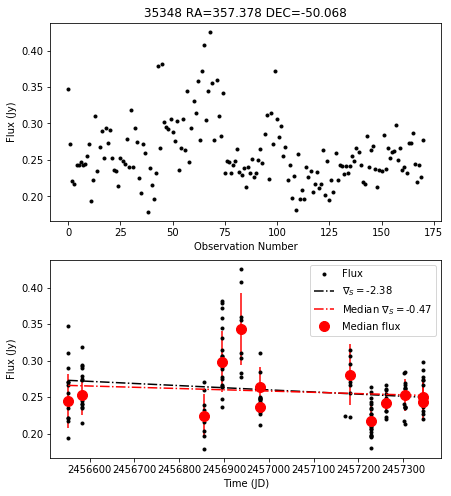

<Figure size 720x864 with 0 Axes>

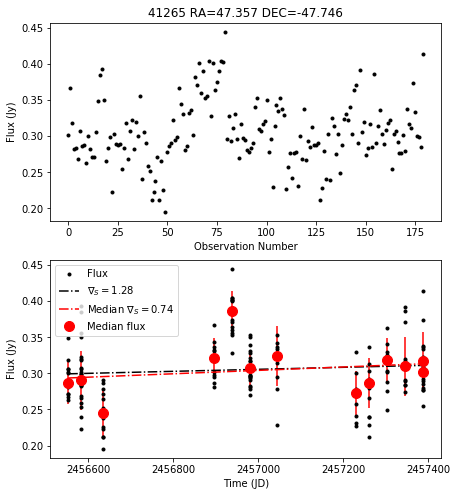

<Figure size 720x864 with 0 Axes>

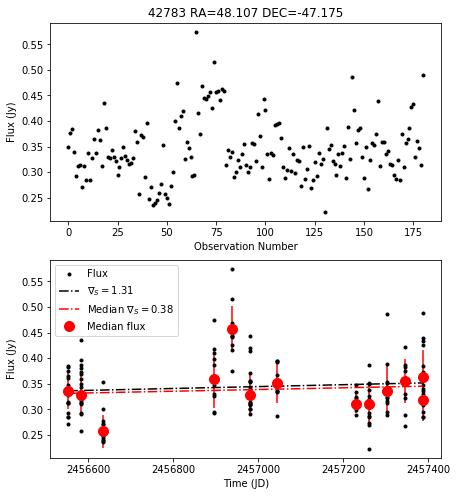

<Figure size 720x864 with 0 Axes>

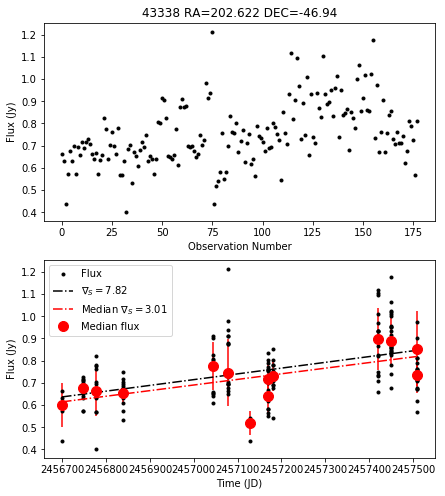

<Figure size 720x864 with 0 Axes>

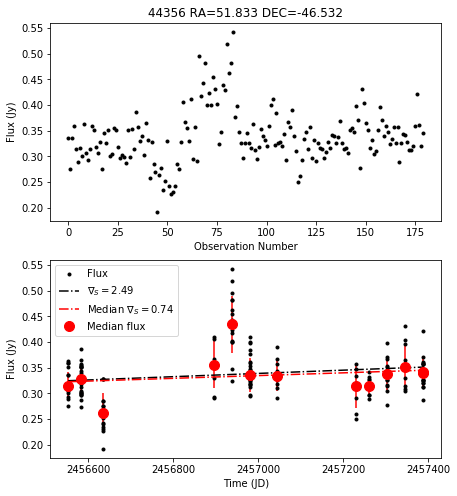

<Figure size 720x864 with 0 Axes>

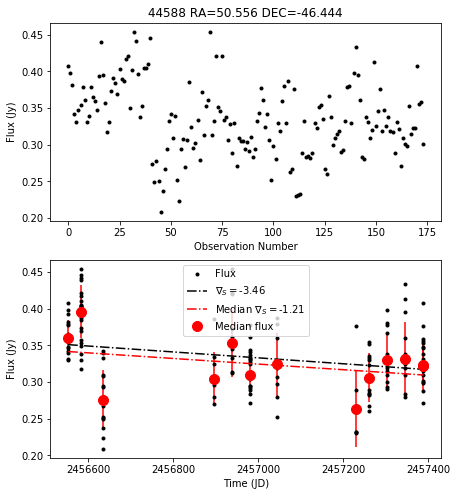

<Figure size 720x864 with 0 Axes>

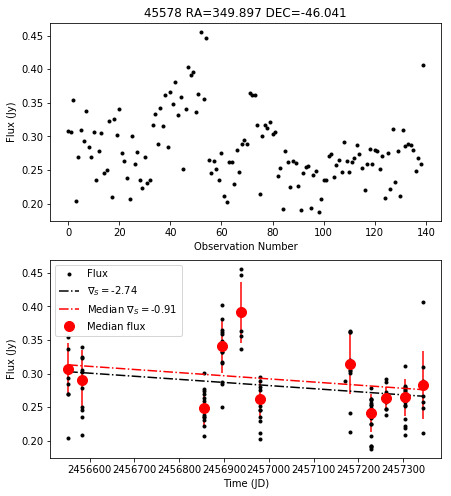

<Figure size 720x864 with 0 Axes>

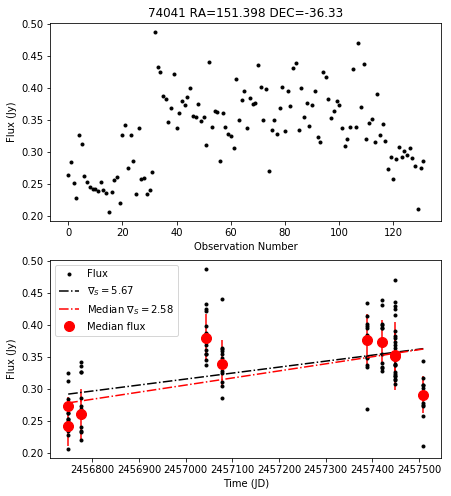

<Figure size 720x864 with 0 Axes>

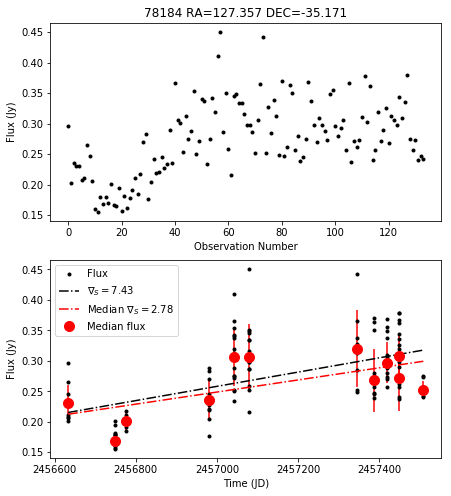

<Figure size 720x864 with 0 Axes>

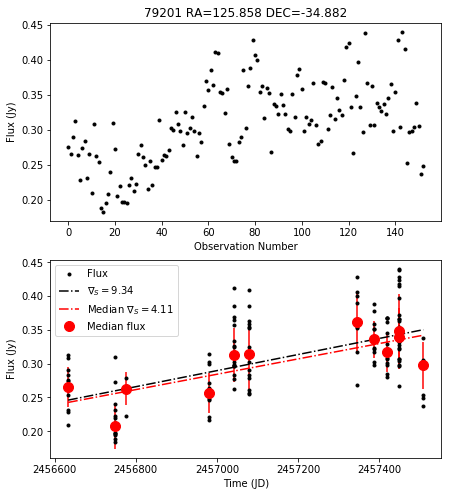

<Figure size 720x864 with 0 Axes>

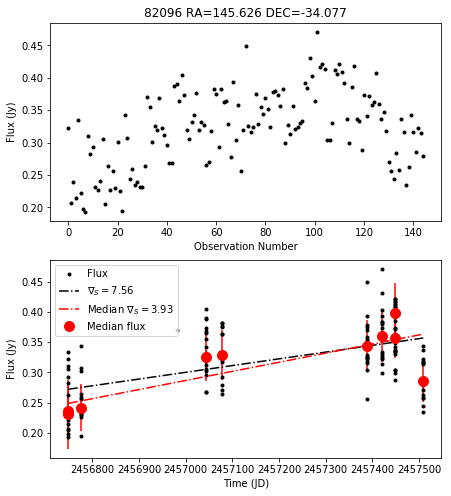

<Figure size 720x864 with 0 Axes>

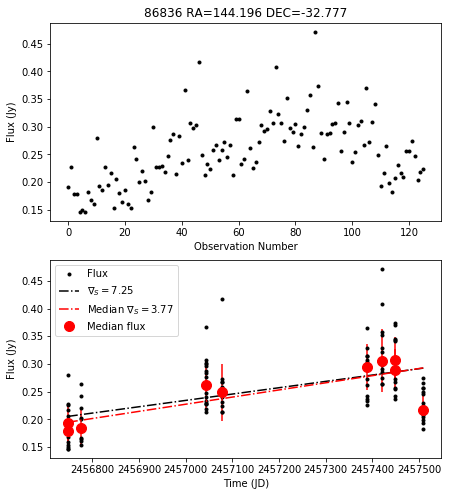

<Figure size 720x864 with 0 Axes>

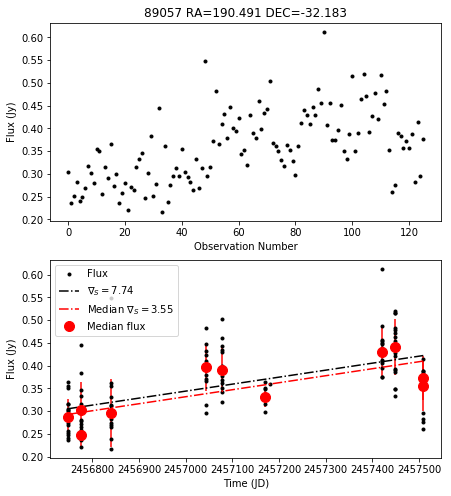

<Figure size 720x864 with 0 Axes>

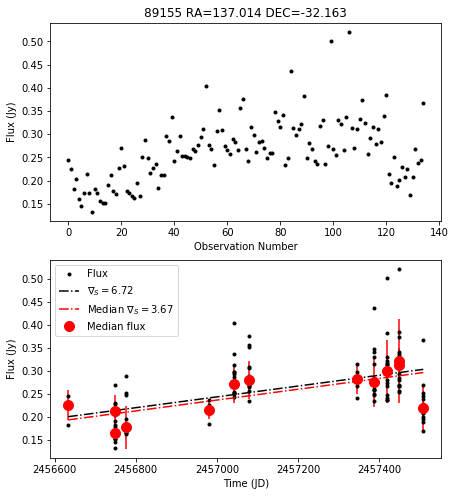

<Figure size 720x864 with 0 Axes>

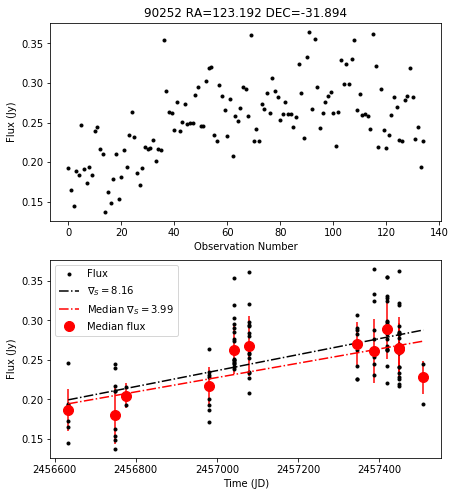

<Figure size 720x864 with 0 Axes>

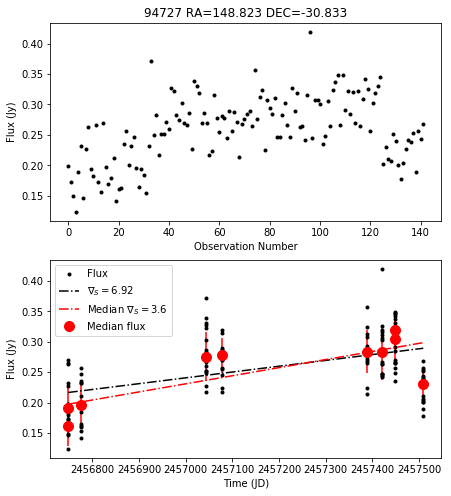

<Figure size 720x864 with 0 Axes>

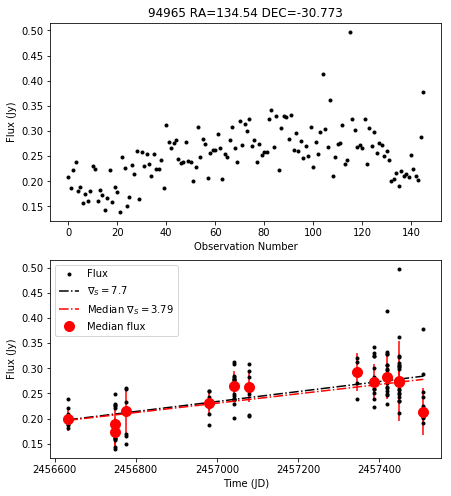

<Figure size 720x864 with 0 Axes>

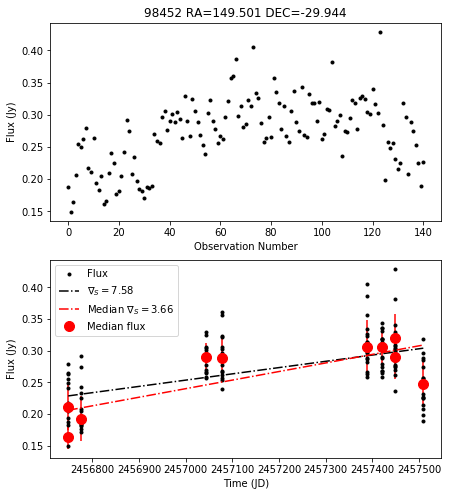

<Figure size 720x864 with 0 Axes>

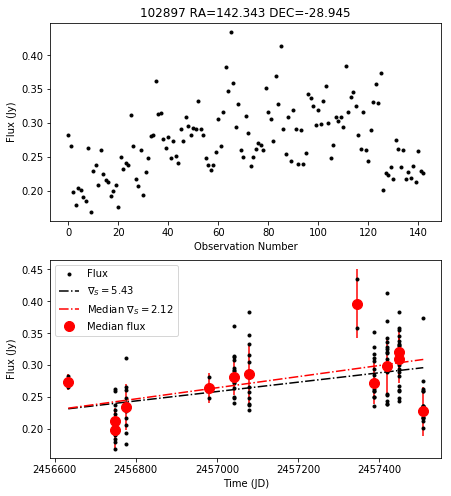

<Figure size 720x864 with 0 Axes>

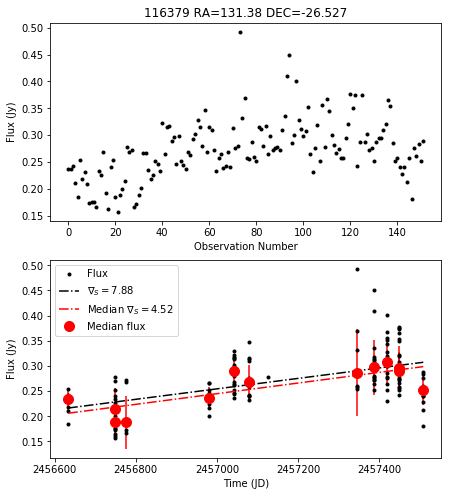

<Figure size 720x864 with 0 Axes>

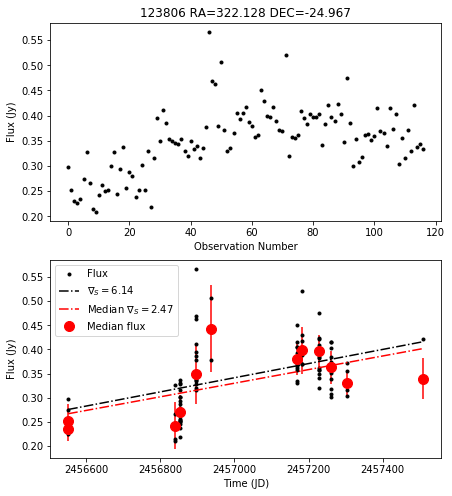

<Figure size 720x864 with 0 Axes>

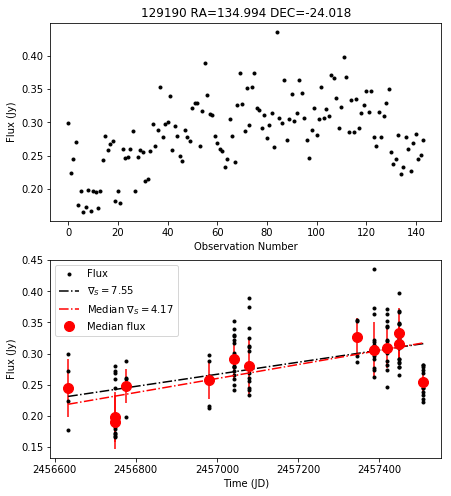

<Figure size 720x864 with 0 Axes>

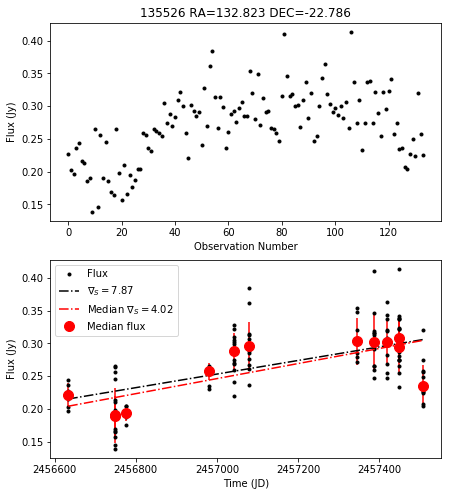

<Figure size 720x864 with 0 Axes>

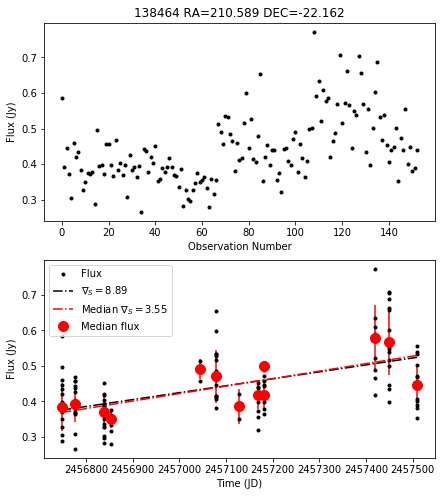

<Figure size 720x864 with 0 Axes>

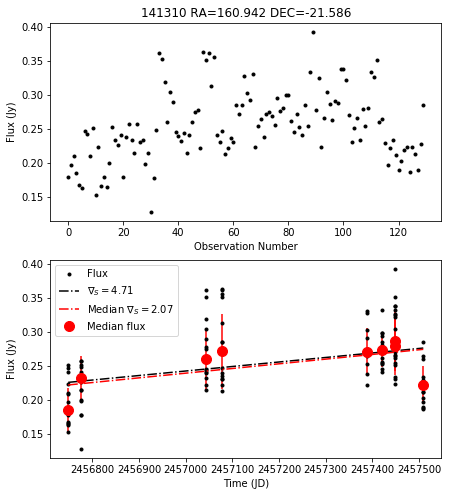

<Figure size 720x864 with 0 Axes>

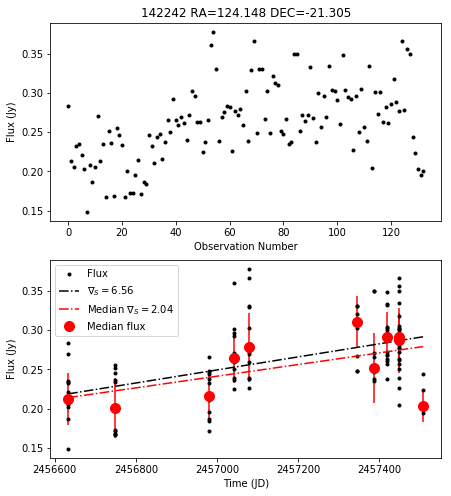

<Figure size 720x864 with 0 Axes>

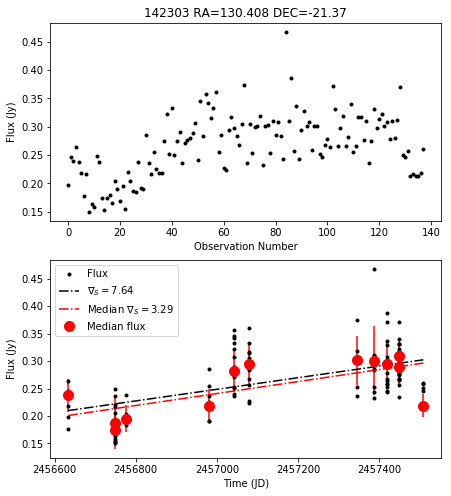

<Figure size 720x864 with 0 Axes>

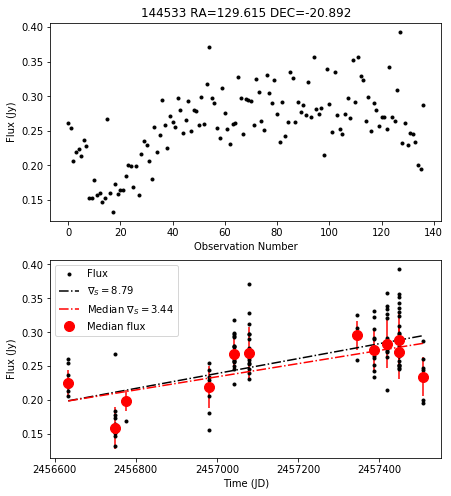

<Figure size 720x864 with 0 Axes>

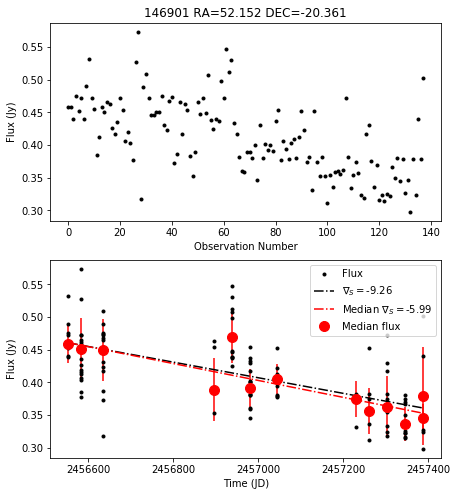

<Figure size 720x864 with 0 Axes>

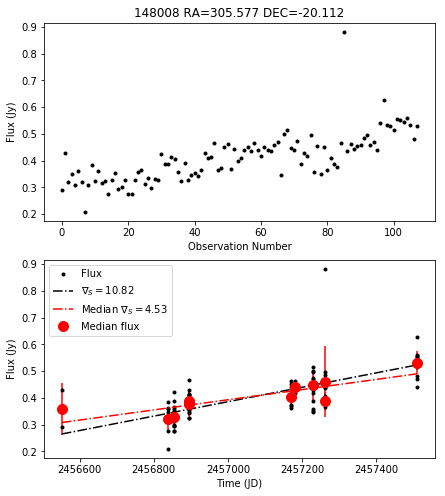

<Figure size 720x864 with 0 Axes>

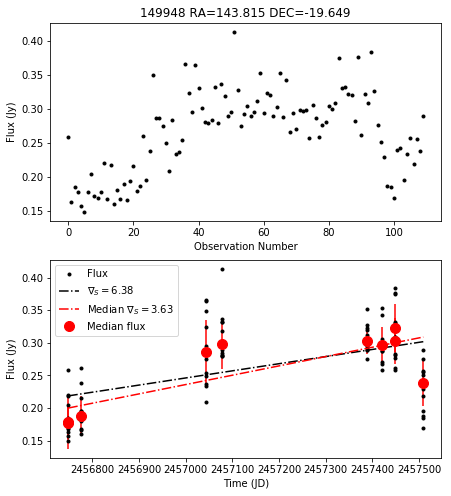

<Figure size 720x864 with 0 Axes>

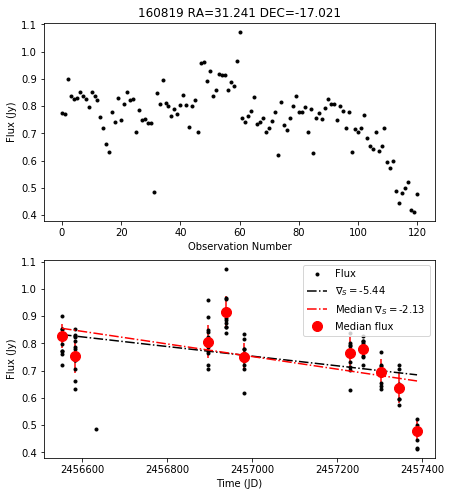

<Figure size 720x864 with 0 Axes>

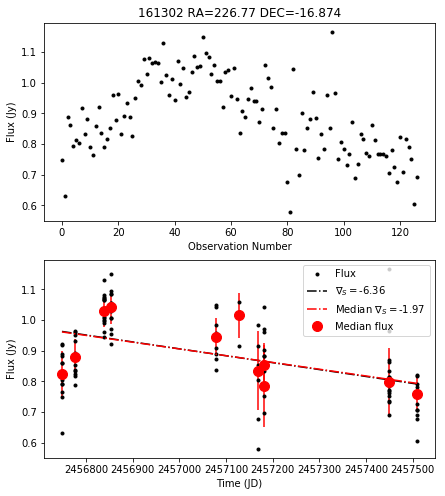

<Figure size 720x864 with 0 Axes>

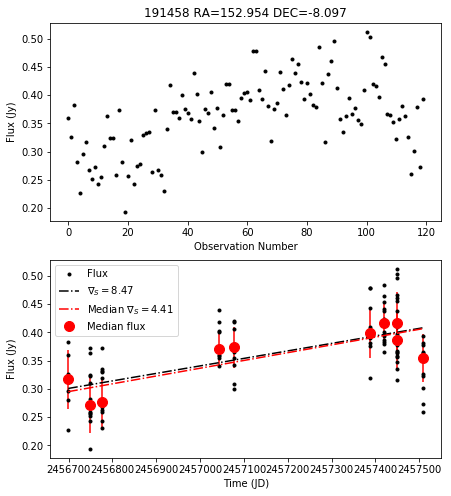

<Figure size 720x864 with 0 Axes>

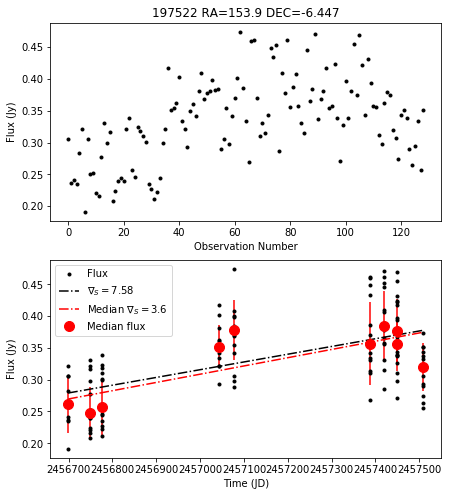

<Figure size 720x864 with 0 Axes>

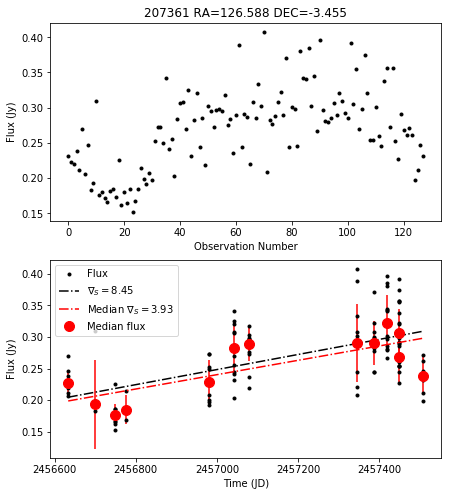

<Figure size 720x864 with 0 Axes>

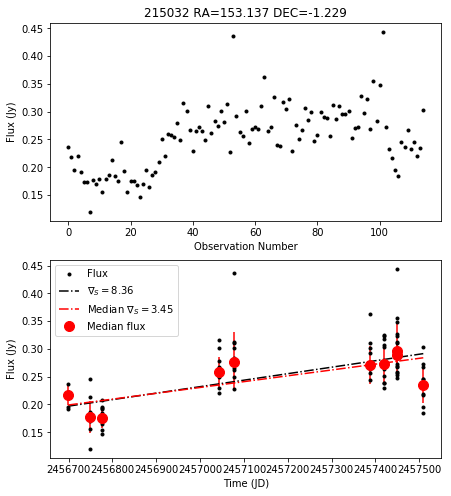

<Figure size 720x864 with 0 Axes>

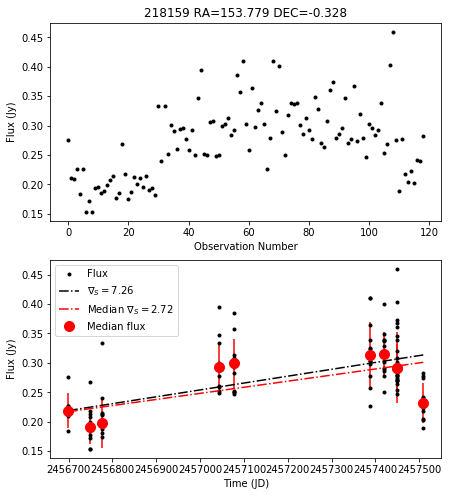

<Figure size 720x864 with 0 Axes>

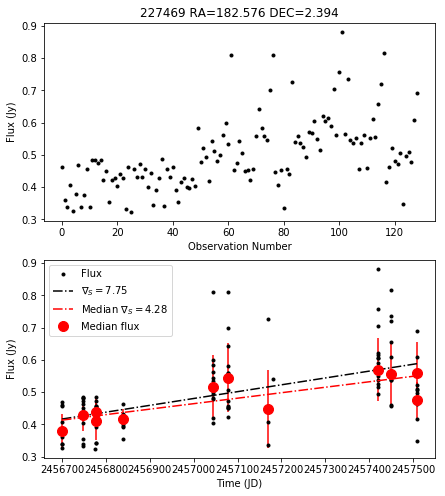

<Figure size 720x864 with 0 Axes>

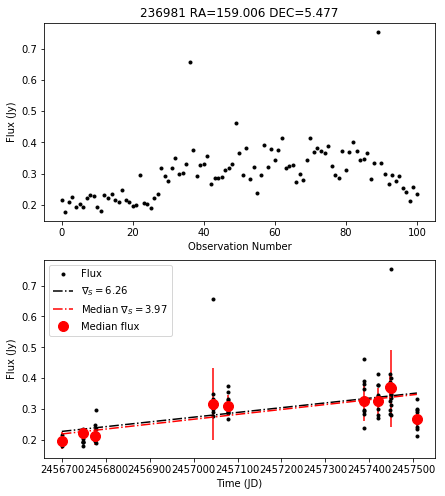

<Figure size 720x864 with 0 Axes>

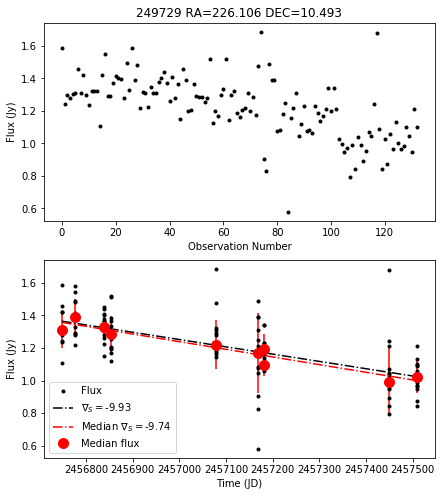

<Figure size 720x864 with 0 Axes>

In [35]:
# Make plots of those sources. 
for n in interesting.source_id:
   plot_lc(n)
   out = plot_n_lc(n)
   get_image(n)

In [36]:
plot_link = []
LC_link = []
avg_link = []
url = []
count = 0
for s in (list(interesting.source_id)):
    plot_link.append("<img src=\'thumbs/"+str(s)+".jpg\'>") 
    LC_link.append("<img src=\'thumbs/"+str(s)+"_LCS.jpg\'>") 
    avg_link.append("<img src=\'thumbs/"+str(s)+"_Avg_LC.jpg\'>") 
    url.append('<a href="http://simbad.u-strasbg.fr/simbad/sim-coo?Coord='+str(interesting.ra.values[count])+'d+'+str(interesting.dec.values[count])+'d&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin&submit=submit+query">Simbad Link</a>')
    count +=1

In [37]:
interesting.insert(0, 'Thumb', plot_link)
interesting.insert(1, 'LCs', LC_link)
interesting.insert(2, 'Avg LC', avg_link)
interesting.insert(3, 'URL', url)

# Add in Simbad indentifiers

In [38]:
tmp = interesting.apply(lambda source: get_response(source.ra, source.dec)[0], axis=1)
interesting.insert(4, 'candidate', tmp)

# RESULTS

In [39]:
pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

## Location plots

In [62]:
def write_loc(ra, dec, color, size):
    rad = size
    colour_str = '# color = '+color
    f.write('circle('+str(ra)+','+str(dec)+','+str(rad)+'\") '+colour_str)
    f.write('\n')  

def write_line(ra1, dec1, ra2, dec2, color):
    colour_str = '# color = '+color
    times = 1.00
    f.write('line('+str(ra1)+','+str(dec1)+','+str(ra2*times)+','+str(dec2*times)+')'+colour_str)
    f.write('\n')
    
f  = open("close.reg", "w")
f.write('fk5')
f.write('\n')

1

In [63]:
#write_loc(stats.ra, stats.dec, 'black', 300)
#write_loc(neighbours.n_id1_ra,neighbours.n_id1_dec, 'cyan', 350 )

n=neighbours[neighbours.source_id_ra < 350]
n=neighbours[neighbours.source_id_ra > 10]

s_ra = list(n.source_id_ra)
s_dec = list(n.source_id_dec)

n1_ra = list(n.n_id1_ra)
n1_dec = list(n.n_id1_dec)

n2_ra = list(n.n_id2_ra)
n2_dec = list(n.n_id2_dec)

n3_ra = list(n.n_id3_ra)
n3_dec = list(n.n_id3_dec)

n4_ra = list(n.n_id4_ra)
n4_dec = list(n.n_id4_dec)

n5_ra = list(n.n_id5_ra)
n5_dec = list(n.n_id5_dec)


for i in range(len(s_ra)):
    write_loc(s_ra[i], s_dec[i], 'black', 300)
    write_loc(n1_ra[i], n1_dec[i], 'magenta', 350)
    write_loc(n2_ra[i], n2_dec[i], 'cyan', 400)
    write_loc(n3_ra[i], n3_dec[i], 'red', 450)
    write_loc(n4_ra[i], n4_dec[i], 'yellow', 500)
    write_loc(n5_ra[i], n5_dec[i], 'blue', 550)
    write_line(s_ra[i], s_dec[i], n1_ra[i], n1_dec[i], 'magenta')
    write_line(s_ra[i], s_dec[i], n2_ra[i], n2_dec[i], 'cyan')
    write_line(s_ra[i], s_dec[i], n3_ra[i], n3_dec[i], 'red')
    write_line(s_ra[i], s_dec[i], n4_ra[i], n4_dec[i], 'yellow')
    write_line(s_ra[i], s_dec[i], n5_ra[i], n5_dec[i], 'blue')

In [58]:
n.head()

source_id  n_id1  n_id2  n_id3  n_id4  n_id5  source_id_ra  source_id_dec  \
0       3045   3140   3400   3302   3645   3288     22.932674     -70.002974   
1       3054   3245   3184   3580   3367   3089     29.589072     -69.987369   
3       3081   3521   3740   3965   4183   4605     11.677428     -69.953863   
4       3083   3220   3358   3136   3634   3974     20.446343     -69.950554   
5       3089   3184   3663   3580   3839   3930     31.236225     -69.928143   

    n_id1_ra  n_id1_dec  ...  n_id3_dec   n_id4_ra  n_id4_dec   n_id5_ra  \
0  22.637308 -69.853363  ... -69.603542  22.477568 -69.099182  21.900402   
1  29.118648 -69.697248  ... -69.207544  28.211346 -69.510528  31.236225   
3  11.225793 -69.268497  ... -68.569749  12.215364 -68.281141  11.093081   
4  20.689724 -69.734914  ... -69.862155  21.114927 -69.110302  20.061765   
5  30.683771 -69.783049  ... -69.207544  30.979662 -68.782196  31.965769   

   n_id5_dec    dist_1    dist_2    dist_3    dist_4    dist_5  
0 -69.626978  0.180695  0.553926  0.473901  0.917546  0.517842  
1 -69.928143  0.332296  0.428277  0.866557  0.674264  0.567508  
3 -67.774091  0.703099  1.028363  1.396887  1.683441  2.189622  
4 -68.559943  0.231345  0.423317  0.314067  0.872050  1.397079  
5 -68.630361  0.239238  0.863806  0.746749  1.149359  1.323007  

[5 rows x 23 columns]

In [76]:
def plot_corr_set(stats):
    set_1 = stats[stats.x_corr_1 > 0.7]
    set_2 = stats[stats.x_corr_2 > 0.7]
    set_3 = stats[stats.x_corr_3 > 0.7]
    set_4 = stats[stats.x_corr_4 > 0.7]
    set_5 = stats[stats.x_corr_5 > 0.7]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    plt.scatter(set_1.ra, set_1.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.x_corr_1_y*50, color='red', label='Neighbour 1')
    plt.scatter(set_2.ra, set_2.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.x_corr_2_y*50, color='blue', label='Neighbour 2')
    plt.scatter(set_3.ra, set_3.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.x_corr_3_y*50, color='green', label='Neighbour 3')
    plt.scatter(set_4.ra, set_4.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.x_corr_4_y*50, color='magenta', label='Neighbour 4')
    plt.scatter(set_5.ra, set_5.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.x_corr_5_y*50, color='cyan', label='Neighbour 5')
    
    # Show the locations of the drift scan centres
    plt.plot([0, 360],[-55, -55], 'k--', linewidth=2, label='Drift scan centre')
    plt.plot([0, 360],[-27, -27], 'k--', linewidth=2)
    plt.plot([0, 360],[3.6, 3.6], 'k--', linewidth=2)

    # Show the cross over regions of the drift scan centres. 
    plt.plot([0, 360],[-41, -41], 'k-.', linewidth=1, label='Drift scan edge')
    plt.plot([0, 360],[-13, -13], 'k--', linewidth=1)
    
    
    
    # Plot the Galactic-Plane
    ra_G  = []
    dec_G = []

    for l_in in range(1, 360):
        c = SkyCoord(b=10*u.degree, l=l_in*u.degree, frame='galactic')
        ra_G.append(c.icrs.ra.degree),
        dec_G.append(c.icrs.dec.degree)
    plt.plot(ra_G, dec_G, 'b-')

    ra_G  = []
    dec_G = []

    for l_in in range(1, 360):
        c = SkyCoord(b=-10*u.degree, l=l_in*u.degree, frame='galactic')
        ra_G.append(c.icrs.ra.degree),
        dec_G.append(c.icrs.dec.degree)
    plt.plot(ra_G, dec_G, 'b-', label='Galactic Plane')   
    
    plt.xlim(0, 360)
    plt.ylim(-90, 30)
    
    
    #plt.plot(139.5236, -12.095543, 'w+', markersize=25,mew=5)
    #plt.plot(79.957171, -45.778828, 'w+', markersize=25,mew=5)
    #plt.plot(50.673825, -37.208227, 'w+', markersize=25,mew=5)
    #plt.plot(252.783945, 4.992588, 'w+', markersize=25,mew=5)
    #plt.plot(201.365063, -43.019, 'w+', markersize=25,mew=5)
    #plt.plot(80.893860, -69.756126, 'w+', markersize=25,mew=5)
    #plt.plot(187.7059, 12.39, 'w+', markersize=25,mew=5)
    
    plt.text(130.5236, -20.095543, "Hydra A", fontsize=18, color='r')
    plt.text(73.957171, -52.778828, "Pic A", fontsize=18, color='r')
    plt.text(46.673825, -45.208227, "For A", fontsize=18, color='r')
    plt.text(246.783945, -2, "Her A", fontsize=18, color='r')
    plt.text(196.365063, -50.019,'Cen A', fontsize=18, color='r')
    #plt.text(75.893860, -76.756126,'LMC', fontsize=18)
    plt.text(182.7059, 5,'Vir A', fontsize=18, color='r')
    plt.text(123, -50, 'Pup A', fontsize=18, color='r')
    
    plt.plot(139.5236, -12.095543, 'r+', markersize=20,mew=5)
    plt.plot(79.957171, -45.778828, 'r+', markersize=20,mew=5)
    plt.plot(50.673825, -37.208227, 'r+', markersize=20,mew=5)
    plt.plot(252.783945, 4.992588, 'r+', markersize=20,mew=5)
    plt.plot(201.365063, -43.019, 'r+', markersize=20,mew=5)
    #plt.plot(80.893860, -69.756126, 'k+', markersize=20,mew=5)
    plt.plot(187.7059, 12.39, 'r+', markersize=20,mew=5)
    plt.plot(127, -42.45, 'r+', markersize=20 ,mew=5)

    
    plt.legend()
    plt.title('Locations of neighbouring sources with correlation coefficients > 0.7')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.tight_layout()
    plt.savefig('correlation_map.png')
    

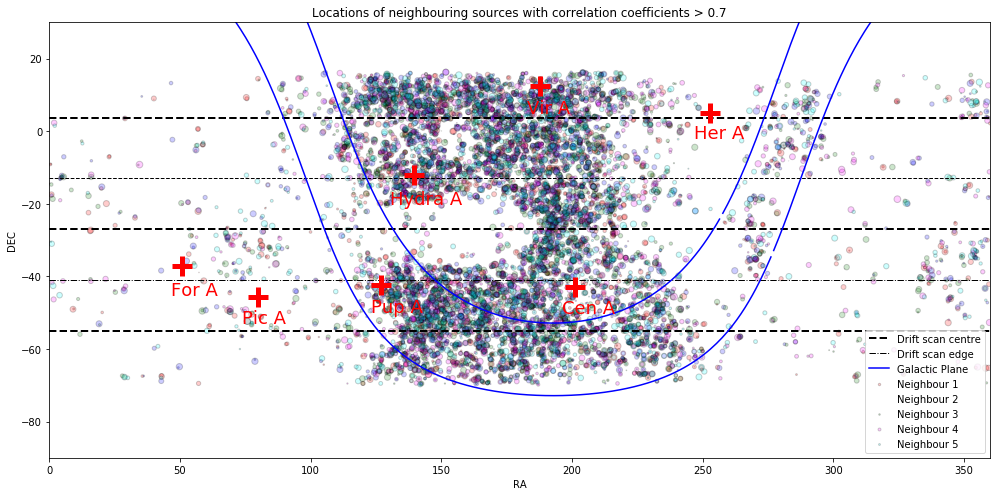

In [77]:
plot_corr_set(stats)

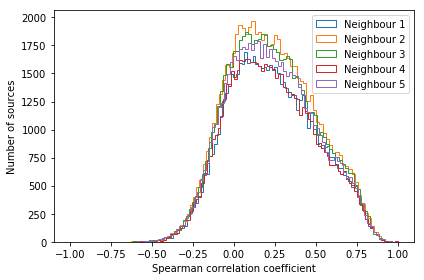

In [10]:
ax=(stats.x_corr_1).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 1')
ax=(stats.x_corr_2).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 2')
ax=(stats.x_corr_3).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 3')
ax=(stats.x_corr_4).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 4')
ax=(stats.x_corr_5).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 5')

plt.ylabel('Number of sources')
plt.xlabel('Spearman correlation coefficient')
plt.legend()
plt.tight_layout()
plt.savefig('S_corr_hist.png')
#ax=(stats.avg_corr).hist(bins=100, figsize=(10, 5), grid=False, histtype='step', label='AVG')

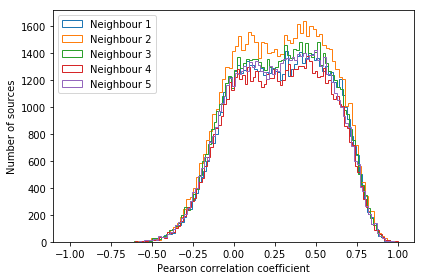

In [14]:
ax=(stats.l_corr_1).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 1')
ax=(stats.l_corr_2).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 2')
ax=(stats.l_corr_3).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 3')
ax=(stats.l_corr_4).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 4')
ax=(stats.l_corr_5).hist(bins=100, figsize=(6, 4), grid=False, histtype='step', label='Neighbour 5')

plt.ylabel('Number of sources')
plt.xlabel('Pearson correlation coefficient')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('P_corr_hist.png')
#ax=(stats.avg_corr).hist(bins=100, figsize=(10, 5), grid=False, histtype='step', label='AVG')

In [15]:
np.median(stats.l_corr_1)

0.29623565159729753

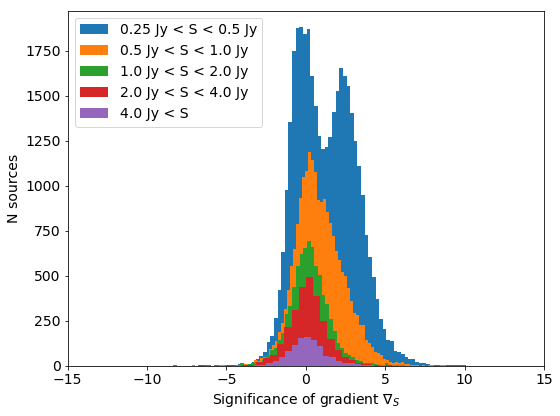

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
#for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#             ax.get_xticklabels() + ax.get_yticklabels()):
#    item.set_fontsize(10)
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
filtered = stats
set_0 = filtered[filtered.mean_raw_peak_flux > 4.0]
set_1 = filtered[(filtered.mean_raw_peak_flux > 2.0) & (filtered.mean_raw_peak_flux < 4.0) ]
set_2 = filtered[(filtered.mean_raw_peak_flux > 1.0) & (filtered.mean_raw_peak_flux < 2.0) ]
set_3 = filtered[(filtered.mean_raw_peak_flux > 0.5) & (filtered.mean_raw_peak_flux < 1.0) ]
set_4 = filtered[(filtered.mean_raw_peak_flux > 0.25) & (filtered.mean_raw_peak_flux < 0.5) ]
p1 = plt.hist(set_4.avg_sig,100,  label="0.25 Jy < S < 0.5 Jy" )
p2 = plt.hist(set_3.avg_sig,140, label="0.5 Jy < S < 1.0 Jy" )
p3 = plt.hist(set_2.avg_sig,100, label="1.0 Jy < S < 2.0 Jy")
p4 = plt.hist(set_1.avg_sig,50, label="2.0 Jy < S < 4.0 Jy")
p5 = plt.hist(set_0.avg_sig,50, label="4.0 Jy < S")

#p1 = plt.hist(set_4.sig,100,  label=" 0.25 Jy > S < 0.5 Jy: Mean of $\\nabla_{S}$ = "+str( round(np.mean (set_4.sig), 1) ))
#p2 = plt.hist(set_3.sig,140, label="0.50 Jy > S < 1.0 Jy: Mean of $\\nabla_{S}$ = "+str( round(np.mean (set_3.sig), 1)))
#p3 = plt.hist(set_2.sig,100, label="1.0 Jy > S < 2.0 Jy: Mean of $\\nabla_{S}$ = "+str( round(np.mean (set_2.sig), 1)))
#p4 = plt.hist(set_1.sig,50, label="2.0 Jy > S < 4.0 Jy: Mean of $\\nabla_{S}$ = "+str( round(np.mean (set_1.sig), 1)))
#p5 = plt.hist(set_0.sig,50, label="4.0 Jy > S: Mean of $\\nabla_{S}$ = "+str( round(np.mean (set_0.sig), 1)))


plt.xlabel('Significance of gradient $\\nabla_{S}$')
plt.xlim(-15, 15)
plt.ylabel('N sources')
plt.tight_layout()
plt.legend()
plt.savefig('sig_hist.png')

In [31]:
np.median(set_0.avg_sig)

0.04657376130253579

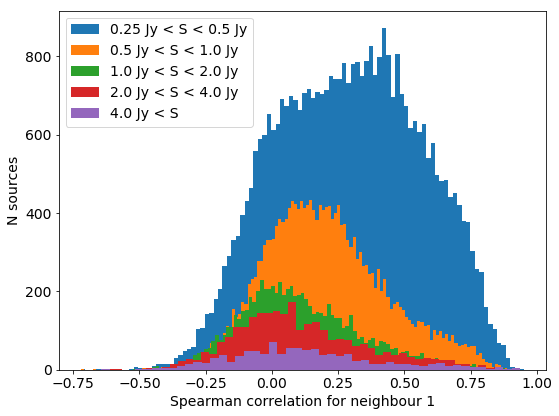

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
filtered = stats
set_0 = filtered[filtered.mean_raw_peak_flux > 4.0]
set_1 = filtered[(filtered.mean_raw_peak_flux > 2.0) & (filtered.mean_raw_peak_flux < 4.0) ]
set_2 = filtered[(filtered.mean_raw_peak_flux > 1.0) & (filtered.mean_raw_peak_flux < 2.0) ]
set_3 = filtered[(filtered.mean_raw_peak_flux > 0.5) & (filtered.mean_raw_peak_flux < 1.0) ]
set_4 = filtered[(filtered.mean_raw_peak_flux > 0.25) & (filtered.mean_raw_peak_flux < 0.5) ]
p1 = plt.hist(set_4.x_corr_1,100,  label="0.25 Jy < S < 0.5 Jy" )
p2 = plt.hist(set_3.x_corr_1,140, label="0.5 Jy < S < 1.0 Jy" )
p3 = plt.hist(set_2.x_corr_1,100, label="1.0 Jy < S < 2.0 Jy")
p4 = plt.hist(set_1.x_corr_1,50, label="2.0 Jy < S < 4.0 Jy")
p5 = plt.hist(set_0.x_corr_1,50, label="4.0 Jy < S")


plt.xlabel('Spearman correlation for neighbour 1')
plt.ylabel('N sources')
plt.tight_layout()
plt.legend()

In [44]:
print(np.mean(set_0.x_corr_1))

0.127974971414022


In [20]:
def plot_corr_set(stats):
    set_1 = stats[stats.l_corr_1 > 0.8]
    set_2 = stats[stats.l_corr_2 > 0.8]
    set_3 = stats[stats.l_corr_3 > 0.8]
    set_4 = stats[stats.l_corr_4 > 0.8]
    set_5 = stats[stats.l_corr_5 > 0.8]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    plt.scatter(set_1.ra, set_1.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.l_corr_1*50, color='red', label='Neighbour 1')
    plt.scatter(set_2.ra, set_2.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.l_corr_2*50, color='blue', label='Neighbour 2')
    plt.scatter(set_3.ra, set_3.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.l_corr_3*50, color='green', label='Neighbour 3')
    plt.scatter(set_4.ra, set_4.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.l_corr_4*50, color='magenta', label='Neighbour 4')
    plt.scatter(set_5.ra, set_5.dec, alpha=0.2, edgecolors='k', lw=1, s=stats.l_corr_5*50, color='cyan', label='Neighbour 5')
    
    # Show the locations of the drift scan centres
    plt.plot([0, 360],[-55, -55], 'k--', linewidth=2, label='Drift scan centre')
    plt.plot([0, 360],[-27, -27], 'k--', linewidth=2)
    plt.plot([0, 360],[3.6, 3.6], 'k--', linewidth=2)

    # Show the cross over regions of the drift scan centres. 
    plt.plot([0, 360],[-41, -41], 'k-.', linewidth=1, label='Drift scan edge')
    plt.plot([0, 360],[-13, -13], 'k--', linewidth=1)
    
    
    
    # Plot the Galactic-Plane
    ra_G  = []
    dec_G = []

    for l_in in range(1, 360):
        c = SkyCoord(b=10*u.degree, l=l_in*u.degree, frame='galactic')
        ra_G.append(c.icrs.ra.degree),
        dec_G.append(c.icrs.dec.degree)
    plt.plot(ra_G, dec_G, 'b-')

    ra_G  = []
    dec_G = []

    for l_in in range(1, 360):
        c = SkyCoord(b=-10*u.degree, l=l_in*u.degree, frame='galactic')
        ra_G.append(c.icrs.ra.degree),
        dec_G.append(c.icrs.dec.degree)
    plt.plot(ra_G, dec_G, 'b-', label='Galactic Plane')   
    
    plt.xlim(0, 360)
    plt.ylim(-90, 30)
    
    
    #plt.plot(139.5236, -12.095543, 'w+', markersize=25,mew=5)
    #plt.plot(79.957171, -45.778828, 'w+', markersize=25,mew=5)
    #plt.plot(50.673825, -37.208227, 'w+', markersize=25,mew=5)
    #plt.plot(252.783945, 4.992588, 'w+', markersize=25,mew=5)
    #plt.plot(201.365063, -43.019, 'w+', markersize=25,mew=5)
    #plt.plot(80.893860, -69.756126, 'w+', markersize=25,mew=5)
    #plt.plot(187.7059, 12.39, 'w+', markersize=25,mew=5)
    
    plt.text(130.5236, -20.095543, "Hydra A", fontsize=18, color='r')
    plt.text(73.957171, -52.778828, "Pic A", fontsize=18, color='r')
    plt.text(46.673825, -45.208227, "For A", fontsize=18, color='r')
    plt.text(246.783945, -2, "Her A", fontsize=18, color='r')
    plt.text(196.365063, -50.019,'Cen A', fontsize=18, color='r')
    #plt.text(75.893860, -76.756126,'LMC', fontsize=18)
    plt.text(182.7059, 5,'Vir A', fontsize=18, color='r')
    plt.text(123, -50, 'Pup A', fontsize=18, color='r')
    
    plt.plot(139.5236, -12.095543, 'r+', markersize=20,mew=5)
    plt.plot(79.957171, -45.778828, 'r+', markersize=20,mew=5)
    plt.plot(50.673825, -37.208227, 'r+', markersize=20,mew=5)
    plt.plot(252.783945, 4.992588, 'r+', markersize=20,mew=5)
    plt.plot(201.365063, -43.019, 'r+', markersize=20,mew=5)
    #plt.plot(80.893860, -69.756126, 'k+', markersize=20,mew=5)
    plt.plot(187.7059, 12.39, 'r+', markersize=20,mew=5)
    plt.plot(127, -42.45, 'r+', markersize=20 ,mew=5)

    
    plt.legend()
    plt.title('Locations of neighbouring sources with correlation coefficients > 0.7')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.tight_layout()
    #plt.savefig('correlation_map.png')
    

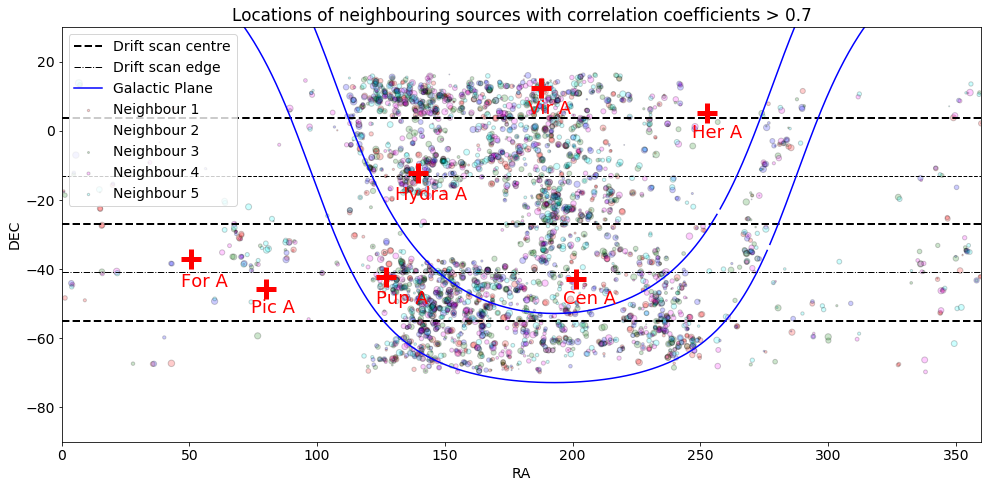

In [21]:
plot_corr_set(stats)

In [33]:
def plot_grad_set(set_pos, set_neg, set_neg_mod, label, name):
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.scatter(set_pos.ra, set_pos.dec, alpha=0.2, edgecolors='k', lw=1, s=set_pos.sig*10, color='red', label='Positive sig grad')
    plt.scatter(set_neg.ra, set_neg.dec, alpha=0.2, edgecolors='k', lw=1, s=set_neg_mod*10, color='blue', label='Negative sig grad')
    
    # Show the locations of the drift scan centres
    plt.plot([0, 360],[-55, -55], 'k--', linewidth=2, label='Drift scan centre')
    plt.plot([0, 360],[-27, -27], 'k--', linewidth=2)
    plt.plot([0, 360],[3.6, 3.6], 'k--', linewidth=2)

    # Show the cross over regions of the drift scan centres. 
    plt.plot([0, 360],[-41, -41], 'k-.', linewidth=1, label='Drift scan edge')
    plt.plot([0, 360],[-13, -13], 'k--', linewidth=1)
    
    plt.legend()
    
    # Plot the Galactic-Plane
    ra_G  = []
    dec_G = []

    for l_in in range(1, 360):
        c = SkyCoord(b=10*u.degree, l=l_in*u.degree, frame='galactic')
        ra_G.append(c.icrs.ra.degree),
        dec_G.append(c.icrs.dec.degree)
    plt.plot(ra_G, dec_G, 'b-')

    ra_G  = []
    dec_G = []

    for l_in in range(1, 360):
        c = SkyCoord(b=-10*u.degree, l=l_in*u.degree, frame='galactic')
        ra_G.append(c.icrs.ra.degree),
        dec_G.append(c.icrs.dec.degree)
    plt.plot(ra_G, dec_G, 'b-')   
    
    plt.xlim(0, 360)
    plt.ylim(-90, 30)
    
    plt.title(label)
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.savefig(name)

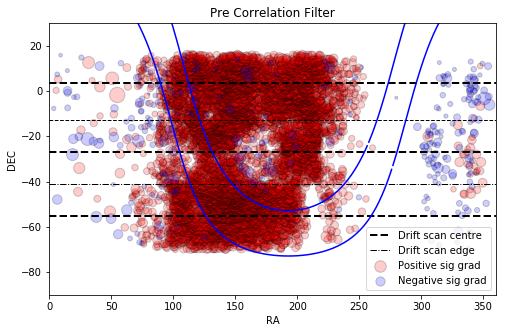

In [35]:
avg_sig_cut = 3.0
avg_flux_cut = 0.0
avg_Mod_cut = 3.0
Mod_cut = 0.0
F = 0
p = 1.0
corr_cut = 1.0

sources = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut)
             & (stats.p_k < p)   
             & (stats.l_corr_1 < corr_cut) 
             & (stats.l_corr_2 < corr_cut)
             & (stats.l_corr_3 < corr_cut)
             & (stats.l_corr_4 < corr_cut)
             & (stats.l_corr_5 < corr_cut)]


set_pos = sources[sources.sig > 3]
set_neg = sources[sources.sig < 3]
set_neg_mod = set_neg['sig'].abs()

plot_grad_set(set_pos, set_neg, set_neg_mod, 'Pre Correlation Filter', 'pre_corr_grad_sources.png')

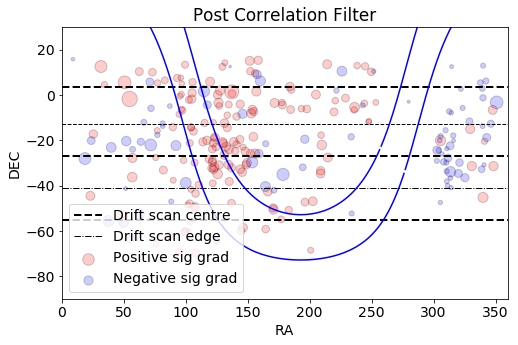

In [38]:
avg_sig_cut = 3.0
avg_flux_cut = 0.0
avg_Mod_cut = 5.0
Mod_cut = 0.0
F = 0
p = 1.0
corr_cut = 0.4

sources = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut)
             & (stats.p_k < p)   
             & (stats.l_corr_1 < corr_cut) 
             & (stats.l_corr_2 < corr_cut)
             & (stats.l_corr_3 < corr_cut)
             & (stats.l_corr_4 < corr_cut)
             & (stats.l_corr_5 < corr_cut)]


set_pos = sources[sources.sig > 3]
set_neg = sources[sources.sig < 3]
set_neg_mod = set_neg['sig'].abs()

plot_grad_set(set_pos, set_neg, set_neg_mod, 'Post Correlation Filter', 'post_corr_grad_sources.png')

In [12]:
corr = filtered_raw_data[filtered_raw_data.source_id == 6628]
corr = corr.sort_values(by='jd')

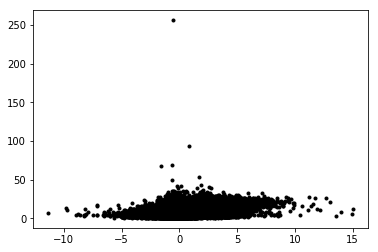

In [26]:
plt.plot( stats.avg_sig,stats.avg_Mod, 'k.')

In [17]:
list(stats)

['index',
 'source_id',
 'ra',
 'dec',
 'mean_raw_peak_flux',
 'std_raw_peak_flux',
 'Mod',
 'length',
 'F_a',
 'p_a',
 'F_k',
 'p_k',
 'sig',
 'grad',
 'fit_error',
 'y_int',
 'avg_sig',
 'avg_grad',
 'avg_fit_error',
 'avg_y_int',
 'avg_std',
 'avg_median',
 'avg_Mod',
 'x_corr_1',
 'x_corr_2',
 'x_corr_3',
 'x_corr_4',
 'x_corr_5',
 'l_corr_1',
 'l_corr_2',
 'l_corr_3',
 'l_corr_4',
 'l_corr_5']

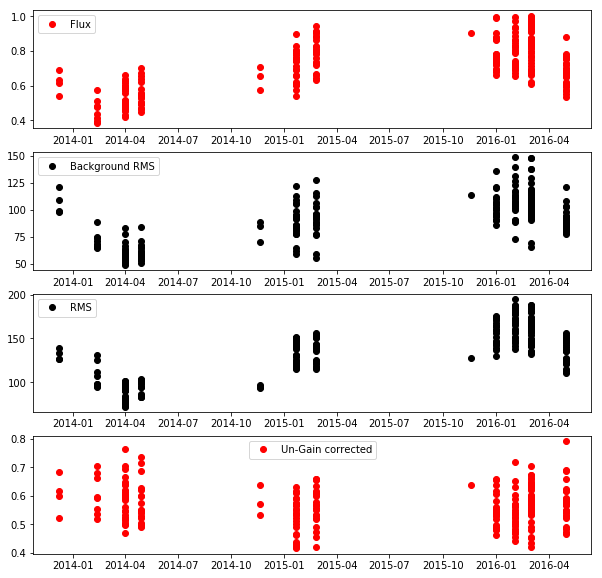

In [66]:
plt.figure(figsize=[10,10])
plt.subplot(4,1,1)
plt.plot(corr.time, corr.raw_peak_flux, 'ro', label='Flux')
plt.legend()
plt.subplot(4,1,2)
plt.plot(corr.time, corr.rms_background, 'ko', label='Background RMS')
plt.legend()
plt.subplot(4,1,3)
plt.plot(corr.time, corr.rms, 'ko', label='RMS')
plt.legend()
plt.subplot(4,1,4)
plt.plot(corr.time, corr.raw_peak_flux*corr.Gain, 'ro', label='Un-Gain corrected')
plt.legend()


In [72]:
n = filtered_raw_data[filtered_raw_data.source_id == 7901]

source_id  n_id1  n_id2  n_id3  n_id4  n_id5  source_id_ra  \
1178       6628   7003   7279   7254   7901   7420    148.009743   

      source_id_dec    n_id1_ra  n_id1_dec  ...  n_id3_dec    n_id4_ra  \
1178     -65.507385  148.477804 -65.114907  ... -64.875722  147.905706   

      n_id4_dec    n_id5_ra  n_id5_dec    dist_1    dist_2    dist_3  \
1178 -64.304305  148.986577 -64.725921  0.438416  0.655287  0.719381   

        dist_4    dist_5  
1178  1.203733  0.882827  

[1 rows x 23 columns]

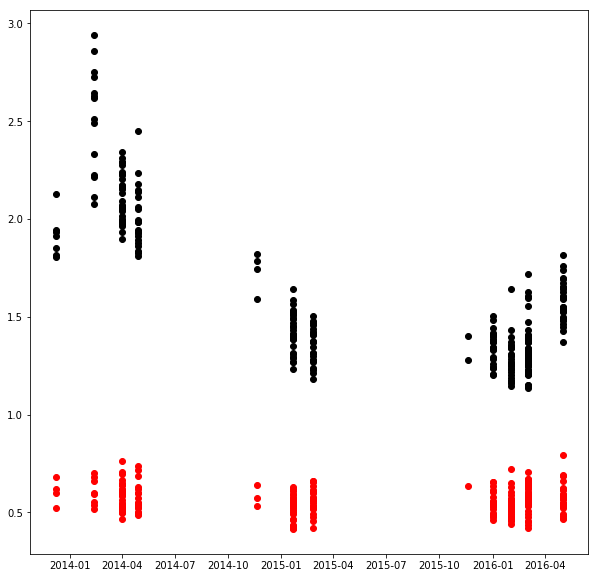

In [76]:
plt.figure(figsize=[10,10])
plt.plot(corr.time, corr.raw_peak_flux*corr.Gain, 'ro', label='Flux')
plt.plot(n.time, n.raw_peak_flux*n.Gain, 'ko', label='Flux')